In [1]:
#NOTE: use paimg9 env
import sys
import os
import numpy as np
import openslide
import matplotlib.pyplot as plt

import matplotlib
matplotlib.use('Agg')
import pandas as pd
import warnings
import torch
import torch.nn as nn

from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import DataLoader, Subset, ConcatDataset
import torch.optim as optim
from pathlib import Path
import PIL
from skimage import filters
import random

    
sys.path.insert(0, '../Utils/')
from Utils import create_dir_if_not_exists
from Utils import generate_deepzoom_tiles, extract_tile_start_end_coords, get_map_startend
from Utils import get_downsample_factor
from Utils import minmax_normalize, set_seed
from Utils import log_message
from Eval import compute_performance, plot_LOSS, compute_performance_each_label, get_attention_and_tileinfo
from train_utils import pull_tiles
from train_utils import ModelReadyData_diffdim, convert_to_dict, prediction_sepatt, BCE_Weighted_Reg, compute_loss_for_all_labels_sepatt
from Model import Mutation_MIL_MT_sepAtt #, Mutation_MIL_MT
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
####################################
######      USERINPUT       ########
####################################
SELECTED_LABEL = ["AR","MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2","PTEN","RB1","TP53","TMB_HIGHorINTERMEDITATE","MSI_POS"]
TRAIN_SAMPLE_SIZE = "ALLTUMORTILES"
TRAIN_OVERLAP = 100
TEST_OVERLAP = 0
SELECTED_FOLD = 0
TUMOR_FRAC_THRES = 0.9
feature_extraction_method = 'retccl'
INCLUDE_TF = False
INCLUDE_CLUSTER = False
N_CLUSTERS = 4


####
#model Para
BATCH_SIZE  = 1
DROPOUT = 0
DIM_OUT = 128
LOSS_FUNC_NAME = "BCE_Weighted_Reg" #"BCE_Weighted_Reg"
SELECTED_MUTATION = "MT"



if SELECTED_MUTATION == "MT":
    N_LABELS = len(SELECTED_LABEL)
else:
    N_LABELS = 1
    
if INCLUDE_TF == False and INCLUDE_CLUSTER == False:
    N_FEATURE = 2048
    feature_type = "emb_only"
elif INCLUDE_TF == True and INCLUDE_CLUSTER == False:
    N_FEATURE = 2049
    feature_type = "emb_and_tf"
elif INCLUDE_TF == False and INCLUDE_CLUSTER == True:
    N_FEATURE = 2049
    feature_type = "emb_and_cluster" + str(N_CLUSTERS)
elif INCLUDE_TF == True and INCLUDE_CLUSTER == True:
    N_FEATURE = 2050
    feature_type = "emb_and_tf_and_cluster" + str(N_CLUSTERS) 
            



##################
###### DIR  ######
##################
proj_dir = '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/'
folder_name = feature_extraction_method + '/MAXSS'+ str(TRAIN_SAMPLE_SIZE)  + '_TrainOL' + str(TRAIN_OVERLAP) +  '_TestOL' + str(TEST_OVERLAP) + '_TFT' + str(TUMOR_FRAC_THRES) + "/split_fold" + str(SELECTED_FOLD) + "/" 
wsi_path = proj_dir + '/data/OPX/'
in_data_path = proj_dir + 'intermediate_data/model_ready_data/feature_' + folder_name + "model_input/"

if INCLUDE_TF == False and INCLUDE_CLUSTER == False:
    feature_type = "emb_only"
elif INCLUDE_TF == True and INCLUDE_CLUSTER == False:
    feature_type = "emb_and_tf"
elif INCLUDE_TF == False and INCLUDE_CLUSTER == True:
    feature_type = "emb_and_cluster" + str(N_CLUSTERS)
elif INCLUDE_TF == True and INCLUDE_CLUSTER == True:
    feature_type = "emb_and_tf_and_cluster" + str(N_CLUSTERS) 

model_data_path =  in_data_path + feature_type + "/"
    
################################################
#Create output-dir
################################################
outdir0 =  proj_dir + "intermediate_data/pred_out011525/" + folder_name + "/DL_" + feature_type + "/" + SELECTED_MUTATION + "/"
outdir1 =  outdir0  + "/saved_model/"
outdir2 =  outdir0  + "/model_para/"
outdir3 =  outdir0  + "/logs/"
outdir4 =  outdir0  + "/predictions/"
outdir5 =  outdir0  + "/perf/"

##################
#Select GPU
##################
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
################################################
#     Model ready data 
################################################
train_data_old = torch.load(model_data_path + 'train_data.pth')
test_data_old = torch.load(model_data_path + 'test_data.pth')
val_data = torch.load(model_data_path + 'val_data.pth')

train_ids_old = torch.load(model_data_path + 'train_ids.pth')
test_ids_old = torch.load(model_data_path + 'test_ids.pth')

train_info_old  = torch.load(model_data_path + 'train_info.pth')
test_info_old  = torch.load(model_data_path + 'test_info.pth')

new_data = torch.load(model_data_path + 'newMSI_test_data.pth')
new_ids = torch.load(model_data_path + 'newMSI_test_ids.pth')
new_info  = torch.load(model_data_path + 'newMSI_test_info.pth')

In [4]:
################################################
#Exclude OPX_085, Prostate cancer find in colorectal site, patterns are for CRC, not for prostate
################################################
exc_idx = test_ids_old.index('OPX_085')
inc_idx = [i for i in range(len(test_data_old)) if i not in [exc_idx]]

#Update old testset
test_data_old = Subset(test_data_old, inc_idx)
removed_id =   test_ids_old.pop(exc_idx)  
removed_info = test_info_old.pop(exc_idx)  

In [5]:
train_add_ids = ['OPX_207','OPX_209','OPX_213','OPX_214','OPX_215']
test_add_ids =  [x for x in new_ids if x not in train_add_ids]
print(train_add_ids)
print(test_add_ids)

['OPX_207', 'OPX_209', 'OPX_213', 'OPX_214', 'OPX_215']
['OPX_208', 'OPX_210', 'OPX_211', 'OPX_212', 'OPX_216']


In [6]:
################################################
#Add Ids in train 
################################################
inc_idx = [new_ids.index(x) for x in train_add_ids]
new_data_train = Subset(new_data, inc_idx)
new_id_train =  list(Subset(new_ids, inc_idx))
new_info_train = list(Subset(new_info, inc_idx))

#Combine old and new train data
train_data  = ConcatDataset([train_data_old, new_data_train])
train_ids = train_ids_old +  new_id_train
train_info = train_info_old +  new_info_train

In [7]:
################################################
#Add Ids in test 
################################################
inc_idx = [new_ids.index(x) for x in test_add_ids]
new_data_test = Subset(new_data, inc_idx)
new_id_test =  list(Subset(new_ids, inc_idx))
new_info_test = list(Subset(new_info, inc_idx))

#Combine old and new train data
test_data  = ConcatDataset([test_data_old, new_data_test])
test_ids = test_ids_old +  new_id_test
test_info = test_info_old +  new_info_test

In [8]:
#count labels in test
test_label_counts = [dt[1] for dt in test_data]
test_label_counts = torch.concat(test_label_counts)
count_ones = (test_label_counts == 1).sum(dim=0)
print(count_ones)
perc_ones = count_ones/test_label_counts.shape[0] * 100
formatted_numbers = [f"{x.item():.1f}" for x in perc_ones]
print(formatted_numbers)

tensor([ 5,  6, 10,  4, 16,  7,  7])
['11.4', '13.6', '22.7', '9.1', '36.4', '15.9', '15.9']


In [9]:
####################################################
#            Test 
####################################################
set_seed(0)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
####################################################################################
#Load model
valid_loss_df = pd.read_csv(outdir1 + "Valid_LOSS.csv")
min_index = valid_loss_df['VALID_LOSS'].idxmin()
print(min_index)
model = Mutation_MIL_MT_sepAtt(in_features = N_FEATURE, 
                        act_func = 'tanh', 
                        drop_out = DROPOUT,
                        n_outcomes = N_LABELS,
                        dim_out = DIM_OUT)
state_dict = torch.load(outdir1 + "model" + str(min_index))
model.load_state_dict(state_dict)
model.to(device)


#Loss function
loss_func = torch.nn.BCELoss()
THRES = 0.53

#predicts
test_pred_prob, test_true_label, test_att, test_loss = prediction_sepatt(test_loader, model, N_LABELS, loss_func, device, SELECTED_MUTATION, SELECTED_LABEL, attention = True)
print("Test-Loss TOTAL: " + "{:.5f}".format(test_loss))


#Prediction df
pred_df_list = []
for i in range(0,N_LABELS):
    if N_LABELS > 1:
        cur_pred_df = pd.DataFrame({"SAMPLE_IDs":  test_ids, 
                                              "Y_True": [l[i] for l in test_true_label], 
                                              "Pred_Prob" :  [l[i] for l in test_pred_prob],
                                              #"Pred_Prob" :  test_pred_prob,
                                              "OUTCOME": SELECTED_LABEL[i]})
    else:
        cur_pred_df = pd.DataFrame({"SAMPLE_IDs":  test_ids, 
                                    "Y_True": [l[i] for l in test_true_label], 
                                    "Pred_Prob" :  test_pred_prob,
                                    "OUTCOME": SELECTED_MUTATION})
        
    pred_df_list.append(cur_pred_df)
pred_df = pd.concat(pred_df_list)

#Add Predict class
pred_df['Pred_Class'] = 0
pred_df.loc[pred_df['Pred_Prob'] > THRES,'Pred_Class'] = 1
pred_df.to_csv(outdir4 + "/pred_df.csv",index = False)


#Compute performance
if SELECTED_MUTATION == "MT":
    perf_df = compute_performance_each_label(SELECTED_LABEL, pred_df, "SAMPLE_LEVEL")
else:
    perf_df = compute_performance_each_label([SELECTED_MUTATION], pred_df, "SAMPLE_LEVEL")
perf_df.to_csv(outdir5 + "/perf.csv",index = True)

print(perf_df.iloc[:,[0,5,6,7,8,9]])
print("AVG AUC:", round(perf_df['AUC'].mean(),2))
print("AVG PRAUC:", round(perf_df['PR_AUC'].mean(),2))
#Use regularization no dropout now has the best performance at avg AUC = 0.61

99
Test-Loss TOTAL: 7.11730
               AUC  Recall  Precision  Specificity    PR_AUC  \
SAMPLE_LEVEL  0.66    1.00       0.11          0.0  0.369672   
SAMPLE_LEVEL  0.53    1.00       0.14          0.0  0.155576   
SAMPLE_LEVEL  0.59    1.00       0.23          0.0  0.308442   
SAMPLE_LEVEL  0.79    1.00       0.09          0.0  0.412173   
SAMPLE_LEVEL  0.63    1.00       0.36          0.0  0.599629   
SAMPLE_LEVEL  0.41    1.00       0.16          0.0  0.149157   
SAMPLE_LEVEL  0.51    0.86       0.19          0.3  0.172676   

                                                       OUTCOME  
SAMPLE_LEVEL                                                AR  
SAMPLE_LEVEL  MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2  
SAMPLE_LEVEL                                              PTEN  
SAMPLE_LEVEL                                               RB1  
SAMPLE_LEVEL                                              TP53  
SAMPLE_LEVEL                           TMB_HIGHorINTERMEDITATE  
SAMP

In [17]:
#Get True Postives
true_postive_ids = {}
for label in SELECTED_LABEL:
    cond = (pred_df['Y_True'] == pred_df['Pred_Class']) & (pred_df['Y_True'] == 1) & (pred_df['OUTCOME'] == label)
    cur_pred_df = pred_df.loc[cond]
    cur_ids = list(cur_pred_df['SAMPLE_IDs'])
    true_postive_ids[label] = cur_ids

#Get true nagative
true_negative_ids = {}
for label in SELECTED_LABEL:
    cond = (pred_df['Y_True'] == pred_df['Pred_Class']) & (pred_df['Y_True'] == 0) & (pred_df['OUTCOME'] == label)
    cur_pred_df = pred_df.loc[cond]
    cur_ids = list(cur_pred_df['SAMPLE_IDs'])
    true_negative_ids[label] = cur_ids

In [22]:
true_postive_ids['MSI_POS']

['OPX_198', 'OPX_208', 'OPX_210', 'OPX_211', 'OPX_212', 'OPX_216']

In [25]:
test_att[i]

[array([0.00949349, 0.0091491 , 0.00945632, 0.0088445 , 0.0089929 ,
        0.00890934, 0.00822923, 0.00843627, 0.00839916, 0.00855191,
        0.00864474, 0.00782727, 0.00818761, 0.0087147 , 0.00904108,
        0.00820163, 0.0074656 , 0.00796768, 0.00886454, 0.0096172 ,
        0.00892518, 0.00837813, 0.00910898, 0.0085093 , 0.00964784,
        0.0091769 , 0.00915927, 0.00863224, 0.00801236, 0.00913143,
        0.00692696, 0.00800814, 0.00847953, 0.00840297, 0.00682031,
        0.00835682, 0.00846373, 0.00833614, 0.00874368, 0.00954379,
        0.00828666, 0.00915753, 0.00905222, 0.00824796, 0.00854373,
        0.0088407 , 0.00830886, 0.00881462, 0.0092098 , 0.00927141,
        0.00898347, 0.00785052, 0.00932946, 0.00719699, 0.0094173 ,
        0.00765173, 0.00788973, 0.00765618, 0.00897484, 0.00907916,
        0.00826599, 0.00784903, 0.0081225 , 0.00896812, 0.00913204,
        0.00731953, 0.00814402, 0.00874295, 0.00813795, 0.00945025,
        0.0093074 , 0.00820566, 0.00841459, 0.00

OPX_198
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_198/' created.
post-processing


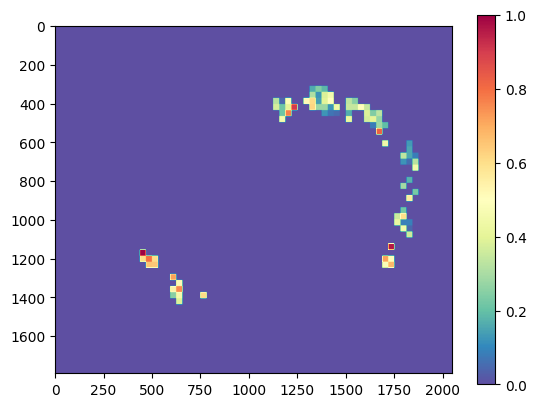

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_198/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_198/bot_tiles/' created.
OPX_208
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_208/' created.
post-processing


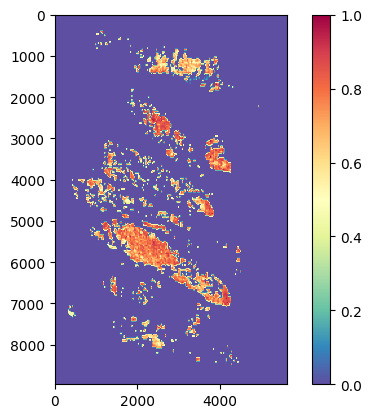

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_208/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_208/bot_tiles/' created.
OPX_210
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_210/' created.
post-processing


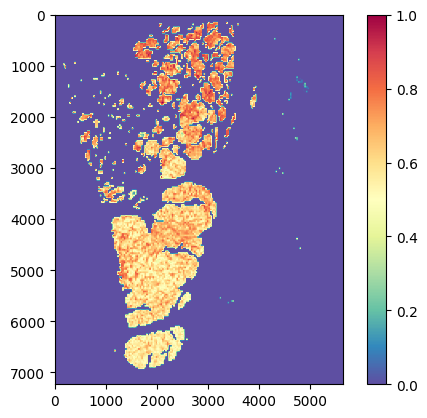

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_210/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_210/bot_tiles/' created.
OPX_211
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_211/' created.
post-processing


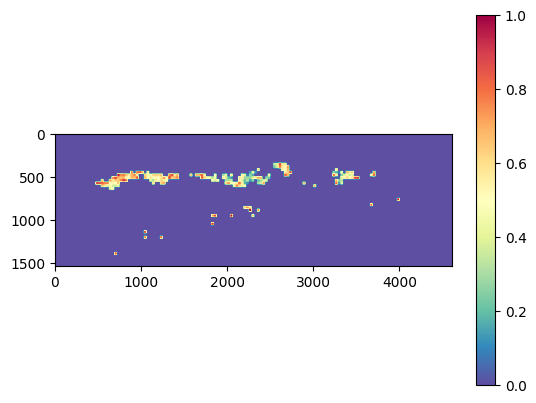

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_211/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_211/bot_tiles/' created.
OPX_212
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_212/' created.
post-processing


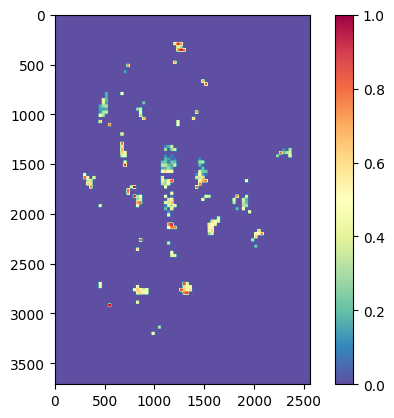

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_212/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_212/bot_tiles/' created.
OPX_216
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_216/' created.
post-processing


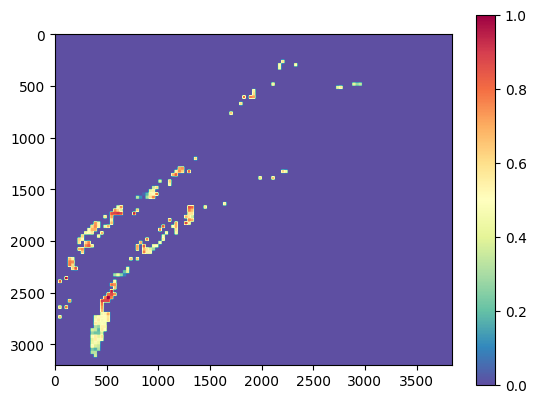

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_216/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/AR/true_pos/OPX_216/bot_tiles/' created.
OPX_198
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_198/' created.
post-processing


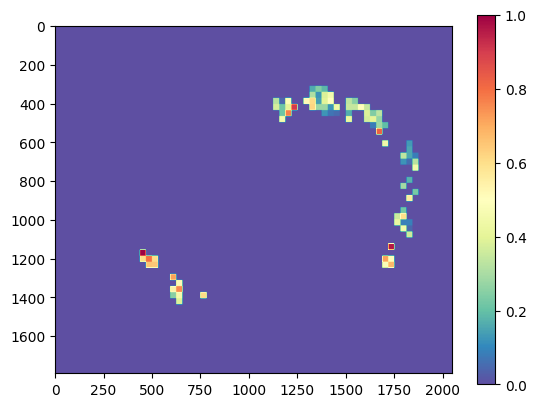

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_198/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_198/bot_tiles/' created.
OPX_208
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_208/' created.
post-processing


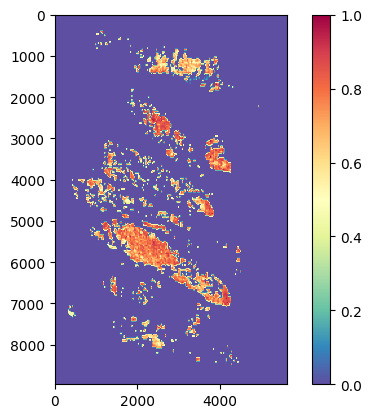

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_208/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_208/bot_tiles/' created.
OPX_210
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_210/' created.
post-processing


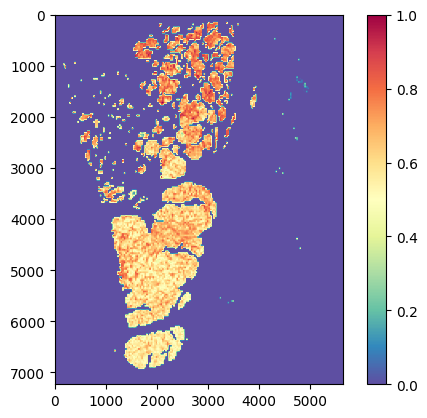

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_210/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_210/bot_tiles/' created.
OPX_211
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_211/' created.
post-processing


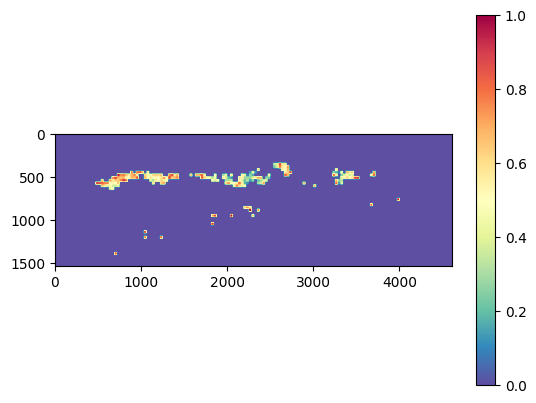

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_211/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_211/bot_tiles/' created.
OPX_212
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_212/' created.
post-processing


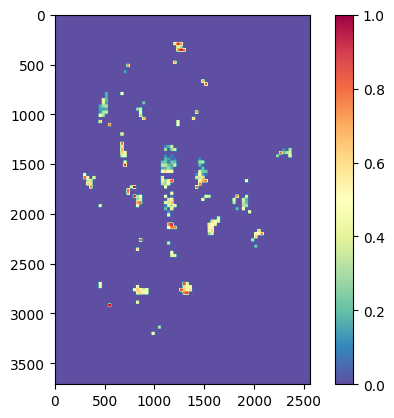

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_212/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_212/bot_tiles/' created.
OPX_216
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_216/' created.
post-processing


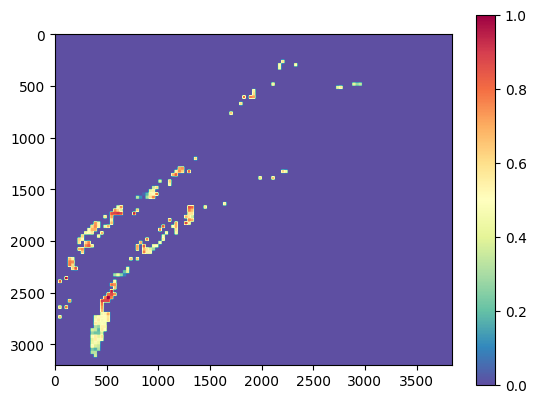

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_216/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2/true_pos/OPX_216/bot_tiles/' created.
OPX_198
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_198/' created.
post-processing


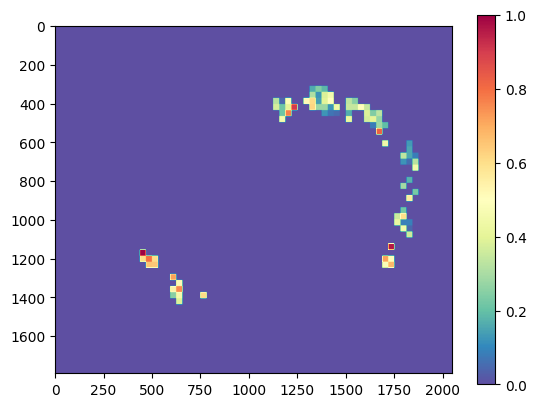

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_198/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_198/bot_tiles/' created.
OPX_208
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_208/' created.
post-processing


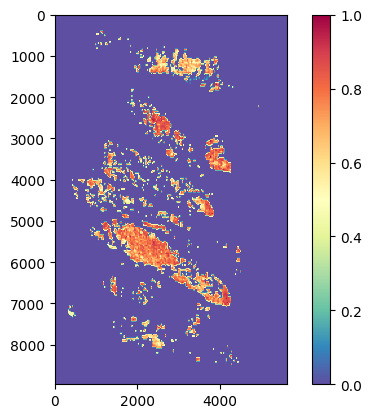

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_208/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_208/bot_tiles/' created.
OPX_210
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_210/' created.
post-processing


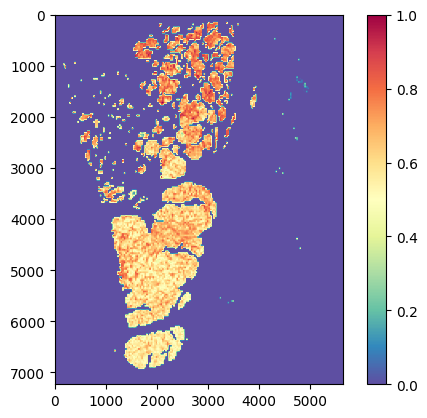

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_210/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_210/bot_tiles/' created.
OPX_211
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_211/' created.
post-processing


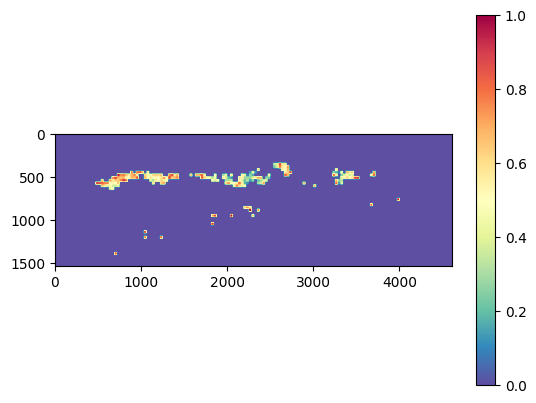

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_211/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_211/bot_tiles/' created.
OPX_212
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_212/' created.
post-processing


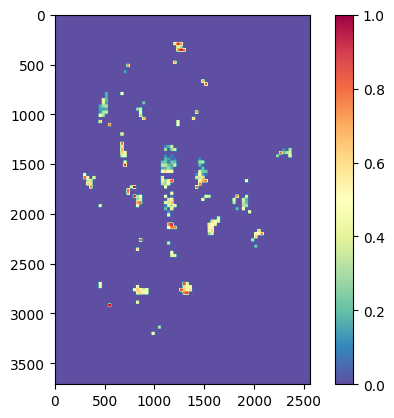

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_212/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_212/bot_tiles/' created.
OPX_216
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_216/' created.
post-processing


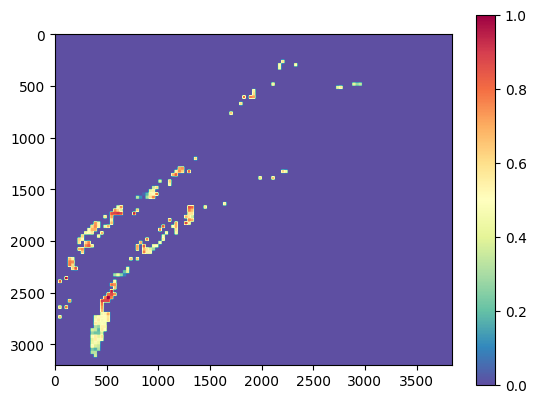

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_216/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/PTEN/true_pos/OPX_216/bot_tiles/' created.
OPX_198
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_198/' created.
post-processing


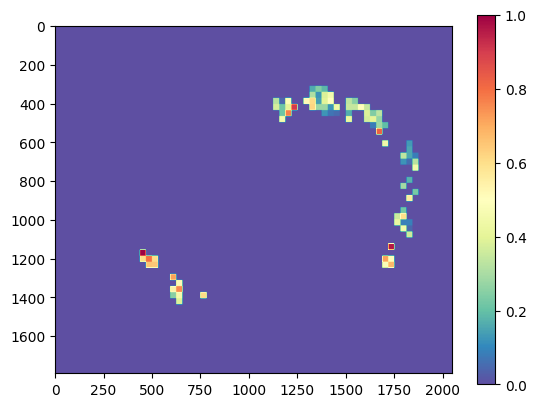

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_198/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_198/bot_tiles/' created.
OPX_208
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_208/' created.
post-processing


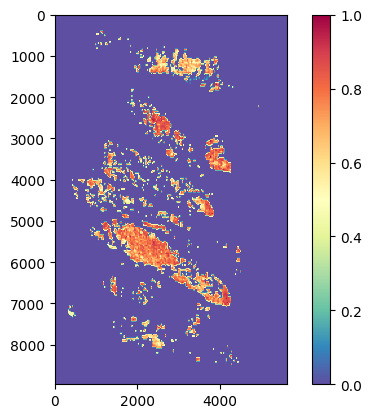

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_208/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_208/bot_tiles/' created.
OPX_210
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_210/' created.
post-processing


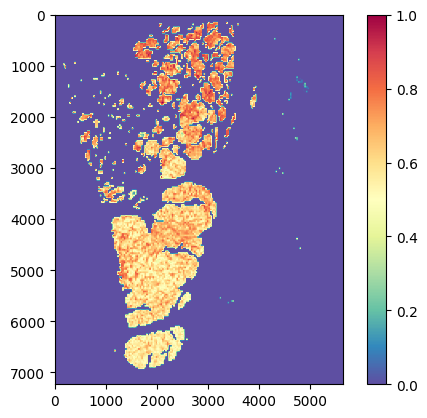

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_210/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_210/bot_tiles/' created.
OPX_211
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_211/' created.
post-processing


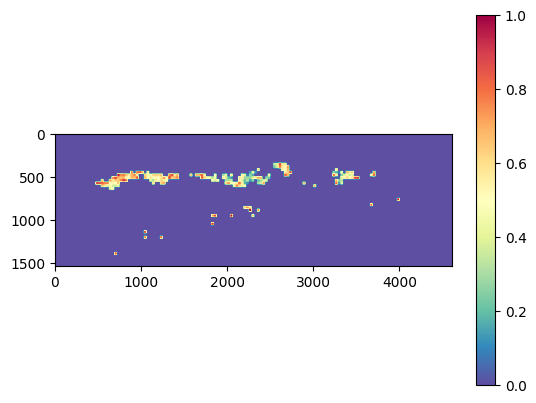

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_211/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_211/bot_tiles/' created.
OPX_212
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_212/' created.
post-processing


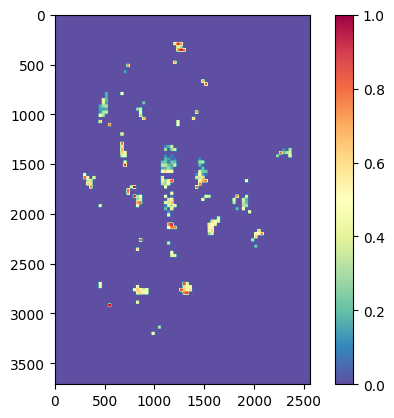

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_212/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_212/bot_tiles/' created.
OPX_216
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_216/' created.
post-processing


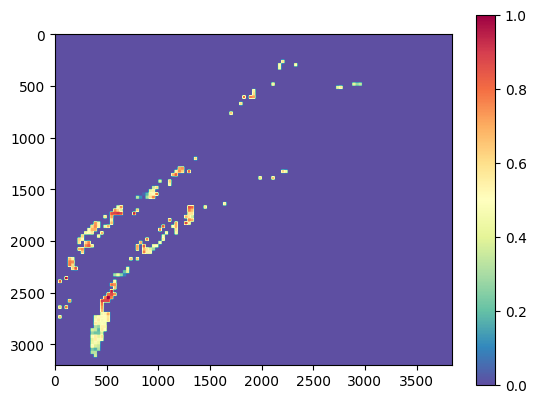

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_216/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/RB1/true_pos/OPX_216/bot_tiles/' created.
OPX_198
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_198/' created.
post-processing


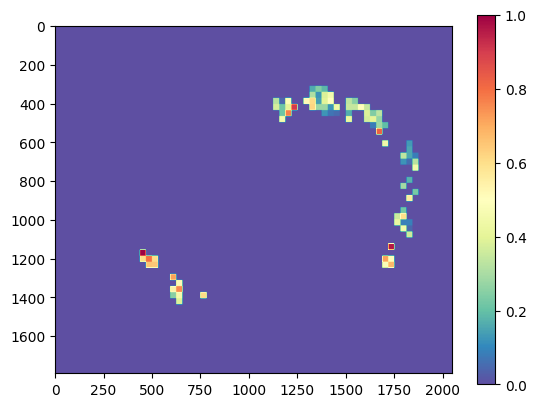

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_198/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_198/bot_tiles/' created.
OPX_208
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_208/' created.
post-processing


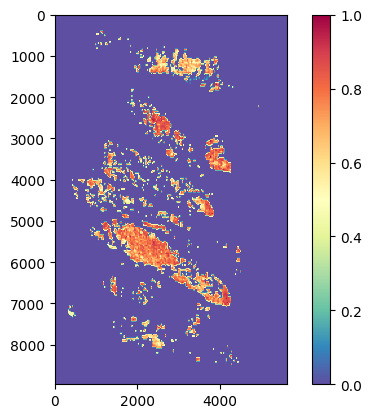

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_208/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_208/bot_tiles/' created.
OPX_210
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_210/' created.
post-processing


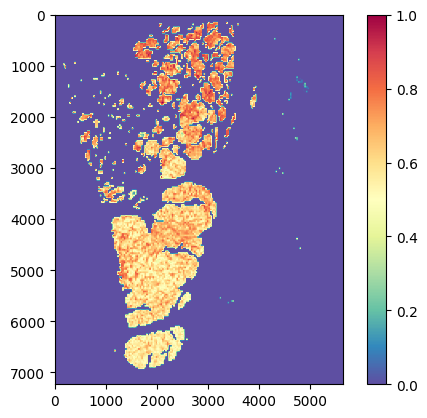

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_210/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_210/bot_tiles/' created.
OPX_211
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_211/' created.
post-processing


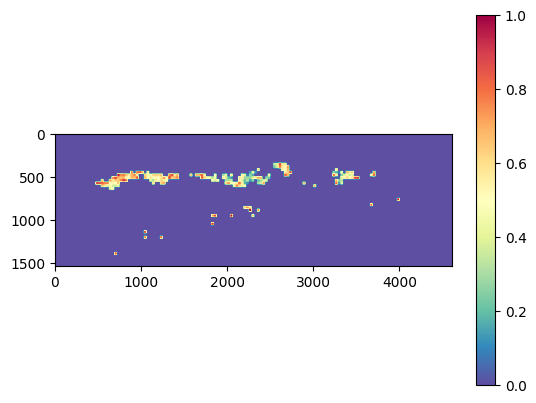

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_211/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_211/bot_tiles/' created.
OPX_212
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_212/' created.
post-processing


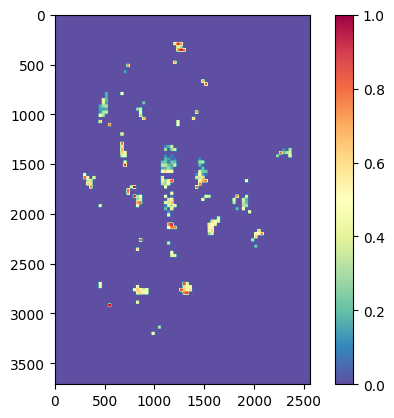

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_212/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_212/bot_tiles/' created.
OPX_216
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_216/' created.
post-processing


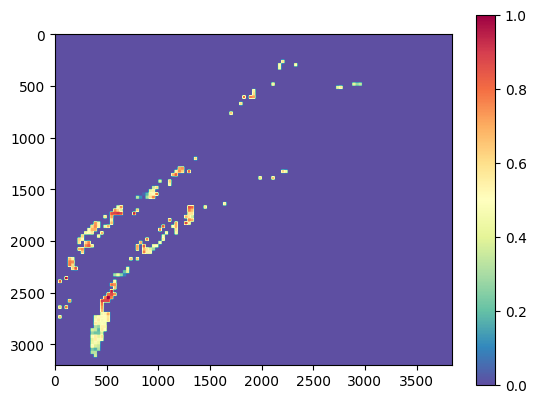

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_216/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TP53/true_pos/OPX_216/bot_tiles/' created.
OPX_198
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TMB_HIGHorINTERMEDITATE/true_pos/OPX_198/' created.
post-processing


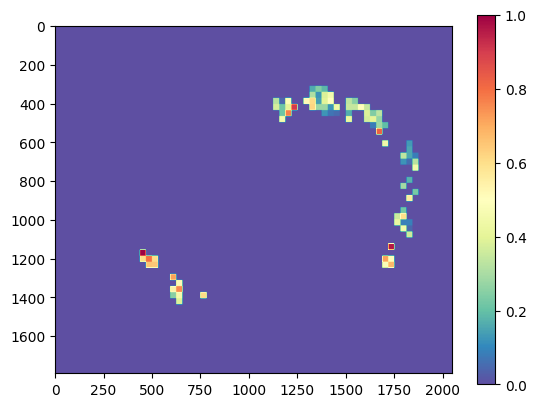

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TMB_HIGHorINTERMEDITATE/true_pos/OPX_198/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TMB_HIGHorINTERMEDITATE/true_pos/OPX_198/bot_tiles/' created.
OPX_208
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TMB_HIGHorINTERMEDITATE/true_pos/OPX_208/' created.
post-processing


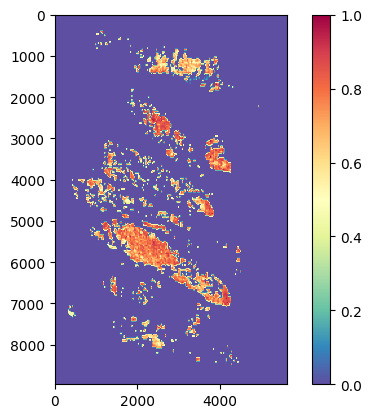

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TMB_HIGHorINTERMEDITATE/true_pos/OPX_208/top_tiles/' created.
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TMB_HIGHorINTERMEDITATE/true_pos/OPX_208/bot_tiles/' created.
OPX_210
Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TMB_HIGHorINTERMEDITATE/true_pos/OPX_210/' created.
post-processing


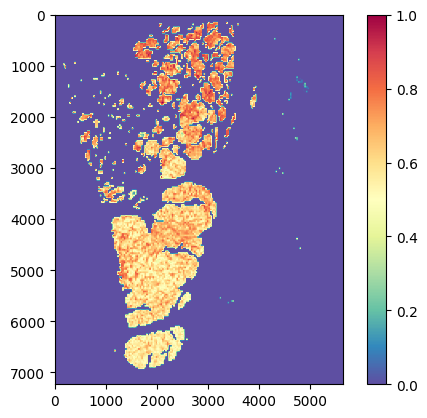

Directory '/fh/fast/etzioni_r/Lucas/mh_proj/mutation_pred/intermediate_data/pred_out011525/retccl/MAXSSALLTUMORTILES_TrainOL100_TestOL0_TFT0.9/split_fold0//DL_emb_only/MT//predictions/TMB_HIGHorINTERMEDITATE/true_pos/OPX_210/top_tiles/' created.


KeyboardInterrupt: 

In [24]:
####################################################################################
#Atention scores
####################################################################################
save_image_size = 250
pixel_overlap = 0
mag_extract = 20
limit_bounds = True
TOP_K = 5
pretrain_model_name = "retccl"
mag_target_prob = 2.5
smooth = False
mag_target_tiss = 1.25
#SELECTED_LABEL = ["AR","MMR (MSH2, MSH6, PMS2, MLH1, MSH3, MLH3, EPCAM)2","PTEN","RB1","TP53","TMB_HIGHorINTERMEDITATE","MSI_POS"]
#selected_outcome = 'RB1'
#selected_att_index = SELECTED_LABEL.index(selected_outcome)
selected_type = "true_pos"

# for selected_outcome in SELECTED_LABEL:
for selected_outcome in SELECTED_LABEL:
    selected_att_index = SELECTED_LABEL.index(selected_outcome)

    selected_ids = true_postive_ids['MSI_POS']
    for tp_pt in selected_ids:
        i = test_ids.index(tp_pt)
        pt = test_ids[i]
        print(pt)
    
        save_location = outdir4 + selected_outcome + "/" + selected_type + "/"
        save_location =  save_location  + pt + "/"
        create_dir_if_not_exists(save_location)
        
        _file = wsi_path + pt + ".tif"
        oslide = openslide.OpenSlide(_file)
        save_name = str(Path(os.path.basename(_file)).with_suffix(''))
        
        
        #Get a Attention, and corresponding tiles
        cur_pt_att = test_att[i][selected_att_index]
        cur_pt_info = test_info[i]
        cur_att_df = get_attention_and_tileinfo(cur_pt_info, cur_pt_att)
        
        
        #Generate tiles
        tiles, tile_lvls, physSize, base_mag = generate_deepzoom_tiles(oslide,save_image_size, pixel_overlap, limit_bounds)
        
        #get level 0 size in px
        l0_w = oslide.level_dimensions[0][0]
        l0_h = oslide.level_dimensions[0][1]
        
        #1.25x tissue detection for mask
        from Utils import get_downsample_factor, get_image_at_target_mag
        from Utils import do_mask_original,check_tissue,whitespace_check
        import cv2
        if 'OPX' in pt:
            rad_tissue = 5
        elif '(2017-0133)' in pt:
            rad_tissue = 2
        lvl_resize_tissue = get_downsample_factor(base_mag,target_magnification = mag_target_tiss) #downsample factor
        lvl_img = get_image_at_target_mag(oslide,l0_w, l0_h,lvl_resize_tissue)
        tissue, he_mask = do_mask_original(lvl_img, lvl_resize_tissue, rad = rad_tissue)
        
        #2.5x for probability maps
        lvl_resize = get_downsample_factor(base_mag,target_magnification = mag_target_prob) #downsample factor
        x_map = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
        x_count = np.zeros((int(np.ceil(l0_h/lvl_resize)),int(np.ceil(l0_w/lvl_resize))), float)
        
        cur_att_df['pred_map_location'] = pd.NA
        for index, row in cur_att_df.iterrows():
            cur_xy = row['TILE_XY_INDEXES'].strip("()").split(", ")
            x ,y = int(cur_xy[0]) , int(cur_xy[1])
            
            #Extract tile for prediction
            lvl_in_deepzoom = tile_lvls.index(mag_extract)
            tile_starts, tile_ends, save_coords, tile_coords = extract_tile_start_end_coords(tiles, lvl_in_deepzoom, x, y) #get tile coords
            map_xstart, map_xend, map_ystart, map_yend = get_map_startend(tile_starts,tile_ends,lvl_resize) #Get current tile position in map
            cur_att_df.loc[index,'pred_map_location'] = str(tuple([map_xstart, map_xend, map_ystart, map_yend]))
        
            #Store predicted probabily in map and count
            try: 
                x_count[map_xstart:map_xend,map_ystart:map_yend] += 1
                x_map[map_xstart:map_xend,map_ystart:map_yend] += row['ATT']
            except:
                pass
        
        print('post-processing')
        x_count = np.where(x_count < 1, 1, x_count)
        x_map = x_map / x_count
        x_map[x_map>1]=1
        
        if smooth == True:
            x_sm = filters.gaussian(x_map, sigma=2)
        if smooth == False:
            x_sm = x_map
        
        he_mask = cv2.resize(np.uint8(he_mask),(x_sm.shape[1],x_sm.shape[0])) #resize to output image size
        #TODO:
        #get cancer_mask:
        # cancer_mask == 
        # x_sm[(he_mask == 1) & (x_sm == 0)] = 0.1 #If tissue map value > 1, then x_sm = 1
        x_sm[he_mask < 1] = 0.001 
        
        plt.imshow(x_sm, cmap='Spectral_r')
        plt.colorbar()
        plt.savefig(os.path.join(save_location, save_name + '_attention.png'), dpi=500,bbox_inches='tight')
        plt.show()
        plt.close()
        
        
        #Top attented tiles
        save_location2 = save_location + "top_tiles/"
        create_dir_if_not_exists(save_location2)
        
        #Get a Attention, and corresponding tiles
        cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = False) 
        cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)
        
        for i in range(TOP_K):
            cur_pulled_img = cur_pulled_img_obj[i][0] #image
            cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
            cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
            coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
            tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
            cur_pulled_img.save(os.path.join(save_location2, tile_save_name))
        
        #Bot attented tiles
        save_location2 = save_location + "bot_tiles/"
        create_dir_if_not_exists(save_location2)
        
        #Get a Attention, and corresponding tiles
        cur_att_df= cur_att_df.sort_values(by = ['ATT'], ascending = True) 
        cur_pulled_img_obj = pull_tiles(cur_att_df.iloc[0:TOP_K], tiles, tile_lvls)
        
        for i in range(TOP_K):
            cur_pulled_img = cur_pulled_img_obj[i][0] #image
            cur_pulled_att = cur_pulled_img_obj[i][1] #attentiom
            cur_pulled_coord = cur_pulled_img_obj[i][2].strip("()").split(", ")  #att tile map coordiates
            coord_save_name = '[xs' + cur_pulled_coord[0] + '_xe' + cur_pulled_coord[1] + '_ys' + cur_pulled_coord[2] + '_ye' + cur_pulled_coord[3] + "]"
            tile_save_name = "ATT" + str(round(cur_pulled_att,2)) + "_MAPCOORD" +  coord_save_name +  ".png"
            cur_pulled_img.save(os.path.join(save_location2, tile_save_name))

In [14]:
#TODO LIST
#1.Attention score
#2. zero gradiant place
test_ids

['OPX_011',
 'OPX_017',
 'OPX_018',
 'OPX_020',
 'OPX_034',
 'OPX_051',
 'OPX_062',
 'OPX_067',
 'OPX_072',
 'OPX_073',
 'OPX_074',
 'OPX_075',
 'OPX_076',
 'OPX_082',
 'OPX_083',
 'OPX_090',
 'OPX_093',
 'OPX_094',
 'OPX_098',
 'OPX_104',
 'OPX_109',
 'OPX_119',
 'OPX_128',
 'OPX_131',
 'OPX_132_1',
 'OPX_133',
 'OPX_135',
 'OPX_154',
 'OPX_155',
 'OPX_166',
 'OPX_170',
 'OPX_171',
 'OPX_179',
 'OPX_180',
 'OPX_184',
 'OPX_185',
 'OPX_197',
 'OPX_198',
 'OPX_200',
 'OPX_208',
 'OPX_210',
 'OPX_211',
 'OPX_212',
 'OPX_216']